# OTH - Twitter Data Analysis
## Lukáš Varga

### 1.1 Creentials

In [62]:
import json

#my credentials
credentials = {}
credentials["CONSUMER_KEY"] = "al3O7cOIE9XNk13NQjRnDhKYk"
credentials["CONSUMER_SECRET"] = "mdWuXncUkVNd9zqg4CFH1rX4Nr0KZ3PqNi2s8E10vbvEFsNtDL"
credentials["BEARER_TOKEN"] = "AAAAAAAAAAAAAAAAAAAAAO8yKwEAAAAAz3eP0eIcjI1ZFPXb72mV7Z5JSHQ%3DVkCRmKYKE6SBapkSWXUmWmC5rQqWmQzfFPxmxhuNrGgF6mmz2S"
credentials["ACCESS_TOKEN"] = "1108440414795849735-eej2D9NxAI1oIVmsGADjrf9yEpRUvN"
credentials["ACCESS_TOKEN_SECRET"] = "S3q0osEtfz6Hwn5wmdyQXsMwbTkU9AdCOpxqGdx7iMfkX"

#save to json
with open("twitter_credentials.json", "w") as file:
    json.dump(credentials, file)
    
print("JSON file with credentials was created!")
print("Done!")

JSON file with credentials was created!
Done!


### 1.2 Initialize

In [63]:
#imports
import json #JSON credentials
import csv #CSV results
import tweepy as tw #twitter API
import pandas as pd #dataframes
from textblob import TextBlob #sentiment
import re #regex
import matplotlib.pyplot as plt #graphs

#asking user about event
EVENT = input("Please enter the event: #")
EVENT = EVENT.lower()
SEARCH_EVENT = "#" + str(EVENT) + "-filter:retweets"

#parameters for filtering
#SINCE_DATE = "2021-01-01"
#ITEM_NUM = 100
SINCE_DATE = input("Enter the oldest possible date of tweets. Use format \"YYYY-MM-DD\": ")
ITEM_NUM = input("Enter the maximum number of tweets: ")
ITEM_NUM = int(ITEM_NUM)

#load credentials
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

#set authentification
auth = tw.OAuthHandler(creds["CONSUMER_KEY"], creds["CONSUMER_SECRET"])
auth.set_access_token(creds["ACCESS_TOKEN"], creds["ACCESS_TOKEN_SECRET"])
api = tw.API(auth, wait_on_rate_limit=True)

print("Done!")

Please enter the event: #trump
Enter the oldest possible date of tweets. Use format "YYYY-MM-DD": 2021-01-01
Enter the maximum number of tweets: 100
Done!


### 2.1 Derive the sentiment

Data set has been loaded!
Computing sentiment...
PNG file of sentiments was created!


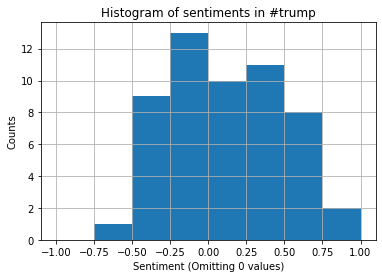

CSV file of sentiments was created!


clear_text_of_tweet  sentiment
0   BorisJohnson realDonaldTrump Conservatives Hun...  -0.200000
1   Trump mob rioters smeared their own feces in U...   0.600000
2   Just do it What Trump must be labeled for what...   0.000000
3   Why are there so many articles about trump not...   0.250000
4   Biden His big challenge will be to recover the...  -0.044444
..                                                ...        ...
95  drmoore president of the ERLC amp an outspoken...   0.000000
96  hollyhamel smrugge biannagolodryga jaketapper ...  -0.300000
97                         So what Trump cok1IZelpexU   0.000000
98  No fkn heart no fkn soul A COWARD trump how co...  -0.312500
99  Evangelical Chinos Christians In Name Onlycokm...   0.000000

[100 rows x 2 columns]

Done!


In [64]:
#get data set
tweets = tw.Cursor(api.search,
                   q = SEARCH_EVENT,
                   lang = "en",
                   since = SINCE_DATE).items(ITEM_NUM)
print("Data set has been loaded!")

print("Computing sentiment...")

#delete all URLs and unallowed chars using REGEX
def remove_url(text):
    return " ".join(re.sub("(\w+:\/\/\w+)|([^0-9A-Za-z\t ])", "", text).split())

clear_tweets = []
for tweet in tweets:
    clear_tweets.append(remove_url(tweet.text))

#creting obj using TextBlob
sentim_obj = []
for tweet in clear_tweets:
    sentim_obj.append(TextBlob(tweet))

#extracting polarity  
sentim_values = []
for tweet in sentim_obj:
    sentim_values.append([str(tweet),tweet.sentiment.polarity])

#creating dataframe with results
sentiment_df = pd.DataFrame(sentim_values, columns=["clear_text_of_tweet","sentiment"])

#histogram (w/o zero values for better visualisation)
clear_sentiment_df = sentiment_df[sentiment_df.sentiment!=0]
x=clear_sentiment_df["sentiment"]

fig, ax = plt.subplots()
ax.set_xlabel("Sentiment (Omitting 0 values)")
ax.set_ylabel("Counts")
ax.set_title("Histogram of sentiments in #"+EVENT)
ax.hist(x,bins=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
plt.grid(True)

#display and save histogram
plt.savefig("01_sentiment_vis.png")
print("PNG file of sentiments was created!")
plt.show()


#display and save dataframe
sentiment_df.to_csv("01_sentiment_res.csv",index=False,sep=";")
print("CSV file of sentiments was created!")
display(sentiment_df)
print("Done!")

### 2.2 Top 10 hashtags and users 

In [65]:
#get data set
tweets = tw.Cursor(api.search,
                   q = SEARCH_EVENT,
                   lang = "en",
                   since = SINCE_DATE).items(ITEM_NUM)

print("Data set has been loaded!")


#TOP10 hashtags
print("Looking for Top 10 hashtags...")

hashtags_dict={}
for tweet in tweets:
    hashtags = tweet.entities.get("hashtags")
    for hashtag in hashtags:
        tag = hashtag['text'].lower()
        if tag in hashtags_dict.keys():
            hashtags_dict[tag] += 1
        else:
            hashtags_dict[tag] = 1
            
sorted_hashtags_dict = sorted(hashtags_dict, key=hashtags_dict.get, reverse=True)
top_hashtags_dict={}
i=0

for hashtag in sorted_hashtags_dict:
    if(i==10):
        break
    top_hashtags_dict[hashtag] = hashtags_dict[hashtag]
    i+=1

    
res_hashtags = []
for hashtag in top_hashtags_dict:
    res_hashtags.append([hashtag,top_hashtags_dict[hashtag]])
    
df_hashtags = pd.DataFrame(res_hashtags, columns=["#hashtag","occurrence"])
df_hashtags.to_csv('02_top10_hashtags.csv',index=False,sep=";")
print("CSV file of Top 10 hashtags was created!")
display(df_hashtags)

#get data set
tweets = tw.Cursor(api.search,
                   q = SEARCH_EVENT,
                   lang = "en",
                   since = SINCE_DATE).items(ITEM_NUM)

#TOP10 users
print("Looking for Top 10 users...")

users_dict={} #user->counts
names_dict={} #user->name
for tweet in tweets:
    user = tweet.author.screen_name
    name = tweet.author.name
    if user in users_dict.keys():
        users_dict[user] += 1
    else:
        users_dict[user] = 1
        names_dict[user] = name
     
    
sorted_users_dict =sorted(users_dict, key=users_dict.get, reverse=True)
top_users_dict={}
top_names_dict={}
i=0

for user in sorted_users_dict:
    if(i==10):
        break
    top_users_dict[user] = users_dict[user]
    top_names_dict[user] = names_dict[user]
    i+=1

res_users = []
for user in top_users_dict:
    res_users.append([user,top_names_dict[user],top_users_dict[user]])
    
df_users = pd.DataFrame(res_users, columns=["@user","real_name","occurrence"])

df_users.to_csv('02_top10_users.csv',index=False,sep=";")
print("CSV file of Top 10 users was created!")
display(df_users)


print("Done!")


Data set has been loaded!
Looking for Top 10 hashtags...
CSV file of Top 10 hashtags was created!


#hashtag  occurrence
0                     trump          72
1                     potus           6
2          trumpcoupattempt           4
3                    antifa           4
4                  american           4
5                      maga           2
6           impeachtrumpnow           2
7                     biden           2
8                       usa           2
9  trumpisanationaldisgrace           2

Looking for Top 10 users...
CSV file of Top 10 users was created!


@user                    real_name  occurrence
0         FaceMac2                      FaceMac           7
1         GmoRight                    Gmo Right           4
2           C_W_UK         Christopher White UK           2
3         mdjohns5                 Mark Johnson           2
4  Archway_Books13                Archway_Books           2
5    thejoshuablog  joshua epstein🏳️‍🌈🖖🏼🗽👨🏼‍💻🇺🇸           2
6      susanhemann                 Susan Hemann           1
7        MarGauFil         Marco Gaucho Filippi           1
8           pdubpk                       PR PRO           1
9        nickizeri                    nickizeri           1

Done!


### 2.3 Followers of a given user

In [66]:
#TODO ask about user

### 2.4 Tweets and profiles of all followers 

In [67]:
#TODO ask about user